# Практическая работа 2.

Решение задачи регрессии в scikit-learn с помощью метрической модели - к-Ближайшие соседи
* Обучение класса `KNeighborsRegressor`
* Поиск лучших гиперпараметров модели с помощью классов `RandomizedSearchCV` и `GridSearchCV`
* Сохранение модели

In [554]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего


# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline. Ни добавить, ни убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

In [555]:
import warnings
warnings.filterwarnings('ignore')

In [556]:
from sklearn.neighbors import KNeighborsRegressor # Регрессия К-Ближайших соседей от scikit-learn

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

In [600]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer #функция для создания объекта из метрики для использования в кросс-валидации

import scipy.stats as stats # статистические функции библиотеки
from sklearn.model_selection import RandomizedSearchCV # для поиска при случайном сэмплировании гиперпараметров

In [594]:
from sklearn.compose import TransformedTargetRegressor

# Набор данных


Набор данных представляет собой датасет, полученный с популярнеого онлайн авто маркетплейса.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведен целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип топлива.


# Загрузка данных

In [558]:
DF = pd.read_csv('/content/cars_raw.csv', delimiter = ',')
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9379 entries, 0 to 9378
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   9379 non-null   int64  
 1   Make                   9379 non-null   object 
 2   Model                  9379 non-null   object 
 3   Used/New               9379 non-null   object 
 4   Price                  9379 non-null   object 
 5   ConsumerRating         9379 non-null   float64
 6   ConsumerReviews        9379 non-null   int64  
 7   SellerType             9379 non-null   object 
 8   SellerName             9379 non-null   object 
 9   SellerRating           9379 non-null   float64
 10  SellerReviews          9379 non-null   int64  
 11  StreetName             9379 non-null   object 
 12  State                  9379 non-null   object 
 13  Zipcode                9379 non-null   object 
 14  DealType               9157 non-null   object 
 15  Comf

## Обработка данных

Из предварительной обработки исключена колонка `Price`, поскольку она является целевой меткой и будет обработана отдельно.

Также откажемся от колонок, которые мы считаем лишними, для уменьшения размеров датасета.

In [559]:
df_new = DF[['Year', 'Make', 'Model', 'Used/New', 'SellerRating', 'FuelType', 'Transmission', 'Mileage', 'Price']].copy()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9379 entries, 0 to 9378
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          9379 non-null   int64  
 1   Make          9379 non-null   object 
 2   Model         9379 non-null   object 
 3   Used/New      9379 non-null   object 
 4   SellerRating  9379 non-null   float64
 5   FuelType      9379 non-null   object 
 6   Transmission  9379 non-null   object 
 7   Mileage       9379 non-null   int64  
 8   Price         9379 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 659.6+ KB


In [560]:
df_new.head()

,Year,Make,Model,Used/New,SellerRating,FuelType,Transmission,Mileage,Price
0,2019,Toyota,Sienna SE,Used,3.3,Gasoline,8-Speed Automatic,29403,"$39,998"
1,2018,Ford,F-150 Lariat,Used,4.8,Gasoline,10-Speed Automatic,32929,"$49,985"
2,2017,RAM,1500 Laramie,Used,4.6,Gasoline,8-Speed Automatic,23173,"$41,860"
3,2021,Honda,Accord Sport SE,Used,4.6,Gasoline,Automatic CVT,10598,"$28,500"
4,2020,Lexus,RX 350,Used,4.8,Gasoline,8-Speed Automatic,28137,"$49,000"


Приведем цену к типу float, для этого уберем знак доллара, заменим поля, где нет цены на 0

In [561]:
df_new['Price'] = df_new['Price'].str.replace('$', '')
df_new['Price'] = df_new['Price'].str.replace('Not Priced', '0')
df_new['Price'] = df_new['Price'].str.replace(',', '').astype(int)

In [562]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9379 entries, 0 to 9378
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          9379 non-null   int64  
 1   Make          9379 non-null   object 
 2   Model         9379 non-null   object 
 3   Used/New      9379 non-null   object 
 4   SellerRating  9379 non-null   float64
 5   FuelType      9379 non-null   object 
 6   Transmission  9379 non-null   object 
 7   Mileage       9379 non-null   int64  
 8   Price         9379 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 659.6+ KB


### Пустые значения

In [563]:
# Проверяю на наличие NaN
df_new.isna().sum()

Year            0
Make            0
Model           0
Used/New        0
SellerRating    0
FuelType        0
Transmission    0
Mileage         0
Price           0
dtype: int64

### Удалим дубли

In [564]:
df_new[df_new.duplicated()]

,Year,Make,Model,Used/New,SellerRating,FuelType,Transmission,Mileage,Price
1645,2019,Buick,Encore Preferred,Used,4.4,Gasoline,6-Speed Automatic,19843,23999
1701,2020,Tesla,Model Y Long Range,Used,2.8,Electric,1-Speed Automatic,15614,68981
1723,2017,Subaru,Impreza 2.0i,Used,4.5,Gasoline,CVT 7-Speed,40060,16823
1737,2019,INFINITI,QX80 Luxe,Used,4.8,Gasoline,7-Speed Automatic,27017,52506
1766,2017,Mercedes-Benz,GLS 450 Base 4MATIC,Used,4.7,Gasoline,9-Speed Automatic,36888,44995
...,...,...,...,...,...,...,...,...,...
9305,2015,Chrysler,200 Limited,Used,1.8,Gasoline,9-Speed Automatic,119417,4250
9311,2019,Mercedes-Benz,C-Class C 300 4MATIC,Mercedes-Benz Certified,4.7,Gasoline,9-Speed Automatic,31619,35493
9319,2017,Mercedes-Benz,GLS 450 Base 4MATIC,Used,4.7,Gasoline,9-Speed Automatic,49001,44762
9335,2018,Ford,F-150 Lariat,Used,3.0,Gasoline,10-Speed Automatic,36000,47989


In [565]:
df_new = df_new.drop_duplicates(keep=False)

In [566]:
df_new.describe()

,Year,SellerRating,Mileage,Price
count,7609.000000,7609.000000,7609.000000,7609.000000
mean,2018.743462,4.407044,36763.732159,40008.127349
std,2.249233,0.632705,25582.129538,21119.369040
min,2001.000000,1.000000,121.000000,0.000000
25%,2018.000000,4.300000,17919.000000,28995.000000
50%,2019.000000,4.600000,31032.000000,36487.000000
75%,2020.000000,4.800000,47513.000000,46000.000000
max,2022.000000,5.000000,234114.000000,449996.000000


Исходя из описательной статистики по всем переменным можно сделать выводы, что аномальных значений не прослеживается

Список числовых и категориальных данных

In [567]:
cat_columns = []
num_columns = []

for column_name in df_new.columns:
    if (df_new[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))

categorical columns:	  ['Make', 'Model', 'Used/New', 'FuelType', 'Transmission'] 
 len =  5
numerical columns:	  ['Year', 'SellerRating', 'Mileage', 'Price'] 
 len =  4


In [568]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [569]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

In [570]:
num_pipe_mileage = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_mileage = ['Mileage']

#
num_pipe_sr = Pipeline([
     ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_sr = ['SellerRating']
#
num_pipe_year = Pipeline([
      ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_year = ['Year']

#
cat_pipe_transmission = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_transmission = ['Transmission']

#
cat_pipe_fuel = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_fuel = ['Fuel_type']

#
cat_pipe_used_new = Pipeline([
  ('encoder', OrdinalEncoder())
])

cat_used_new = ['Used/New']

#
cat_pipe_make = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_make = ['Make']

#
cat_pipe_model = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_model = ['Model']

# # Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_mileage', num_pipe_mileage, num_mileage),
    ('num_sr', num_pipe_sr, num_sr),
    ('num_year', num_pipe_year, num_year),
])

# # и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_mileage', num_pipe_mileage, num_mileage),
    ('num_sr', num_pipe_sr, num_sr),
    ('num_year', num_pipe_year, num_year),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_fuel', cat_pipe_fuel, cat_fuel),
    ('cat_used_new', cat_pipe_used_new, cat_used_new),
    ('cat_make', cat_pipe_make, cat_make),
    ('cat_model', cat_pipe_model, cat_model),
    # ('cat_engine', cat_pipe_engine, cat_engine),
])

In [571]:
preprocessors_all

ColumnTransformer(transformers=[('num_mileage',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler', StandardScaler())]),
                                 ['Mileage']),
                                ('num_sr',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler', StandardScaler())]),
                                 ['SellerRating']),
                                ('num_year',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold...
                                ('cat_make',
                                 Pipeline(steps=[('replace_rare',
                                                  RareGrouper(threshold=0.001)),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make']),
                                ('cat_model',
                                 Pipeline(steps=[('replace_rare',
                                                  RareGrouper(threshold=0.0001)),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Model'])])

In [572]:
# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns_num = np.hstack([num_mileage,
                        num_sr,
                        num_year,])

# Регрессия Методом к-Ближайших Соседей

In [573]:
X,y = df_new.drop(columns = ['Price']), df_new['Price']

# разбиваем на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=42)

# Оценим модель с использованием только числовых данных

In [574]:
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_num.fit_transform(X_train)
# потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

### Обучаем модель

In [575]:
model = KNeighborsRegressor(n_neighbors = 20, weights = 'distance')

model.fit(X_train_prep, y_train);

### Оценка метрик

In [576]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [577]:
print(f"r2 на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9336
r2 на валидационной выборке: -0.0550
mse на тренировочной выборке: 28925467.6229
mse на валидационной выборке: 496210262.9750


Совсем не понимаю почему r2 на валидационной выборке такой низкий, мои попытки улучшить не увенчались успехом. Хотелось бы услышать рекомендации на этот счет, заранее спасибо.

In [578]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [579]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [580]:
cross_validation (X_train_prep, y_train,
                  model,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state= 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.017908,0.018606,-0.226718,-4.697056e+08,-12430.563759,-226435.500000
1,0.006545,0.028856,-0.380051,-6.334874e+08,-13140.789221,-315486.572441
2,0.039485,0.034388,-0.012260,-3.740754e+08,-11567.208155,-261600.500000
3,0.016216,0.035460,0.142272,-2.812009e+08,-11676.227014,-125557.000000
4,0.010829,0.020056,-0.035590,-5.069452e+08,-12649.509089,-263392.666667




test_R2     -1.024693e-01
test_-MSE   -4.530829e+08
test_-MAE   -1.229286e+04
test_-Max   -2.384944e+05
dtype: float64


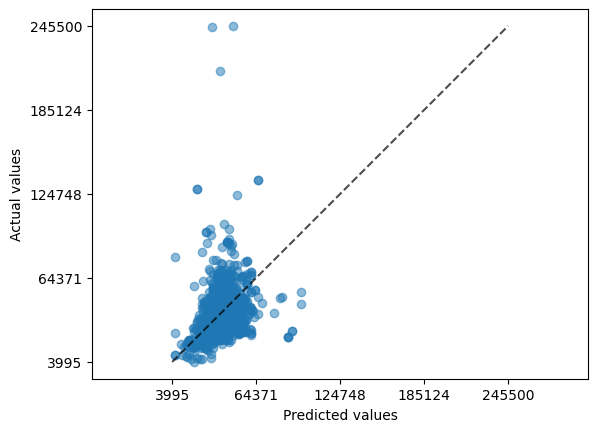

In [581]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

## Поиск Лучших Гиперпараметров с Помощью Рандомизированного Поиска

In [582]:
# словарь гиперпараметров в виде
# обозначение гиперпараметров : из какого распределения сэмплируем
# обозначение должно "досимвольно" совпадать с тем что в документации
parameters = {'n_neighbors':stats.randint(1,50), # задаем распределение как равномерное от 1 до 50
              'weights':['uniform', 'distance']}

# количество итераций
n_iter_search = 20

kNN_search = RandomizedSearchCV(estimator = KNeighborsRegressor(),  # оптимизируем нашу модель
                                verbose = 3,  # 3 чтобы он всё подробно расписал, если не интересно - пишем 0
                          param_distributions=parameters , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                          n_iter = n_iter_search # количество итераций
                          )

In [583]:
kNN_search.fit(X_train_prep, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=41, weights=uniform;, score=0.154 total time=   0.1s
[CV 2/5] END ...n_neighbors=41, weights=uniform;, score=0.120 total time=   0.1s
[CV 3/5] END ...n_neighbors=41, weights=uniform;, score=0.144 total time=   0.1s
[CV 4/5] END ...n_neighbors=41, weights=uniform;, score=0.235 total time=   0.1s
[CV 5/5] END ...n_neighbors=41, weights=uniform;, score=0.114 total time=   0.1s
[CV 1/5] END .n_neighbors=29, weights=distance;, score=-0.197 total time=   0.1s
[CV 2/5] END .n_neighbors=29, weights=distance;, score=-0.357 total time=   0.0s
[CV 3/5] END ..n_neighbors=29, weights=distance;, score=0.008 total time=   0.0s
[CV 4/5] END ..n_neighbors=29, weights=distance;, score=0.155 total time=   0.0s
[CV 5/5] END .n_neighbors=29, weights=distance;, score=-0.025 total time=   0.0s
[CV 1/5] END .n_neighbors=22, weights=distance;, score=-0.219 total time=   0.0s
[CV 2/5] END .n_neighbors=22, weights=distance;

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
                   estimator=KNeighborsRegressor(), n_iter=20,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a29e7419cc0>,
                                        'weights': ['uniform', 'distance']},
                   verbose=3)

In [584]:
kNN_search.best_estimator_

KNeighborsRegressor(n_neighbors=30)

In [589]:
kNN_search.best_params_

{'n_neighbors': 30, 'weights': 'uniform'}

In [591]:
kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train_prep, y_train);

In [592]:
print(f"r2 на тренировочной выборке: {calculate_metric(kNNbest, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(kNNbest, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(kNNbest, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(kNNbest, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.1772
r2 на валидационной выборке: 0.1019
mse на тренировочной выборке: 358326575.2439
mse на валидационной выборке: 422433551.8375


In [593]:
DF_reg=pd.DataFrame(kNN_search.cv_results_)
DF = DF_reg[['param_n_neighbors','param_weights',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
11,30,uniform,0.155832,0.046504,1
7,39,uniform,0.154674,0.043056,2
10,40,uniform,0.154566,0.043479,3
3,38,uniform,0.154499,0.043434,4
14,36,uniform,0.154064,0.045782,5
0,41,uniform,0.153325,0.043574,6
12,41,uniform,0.153325,0.043574,6
6,44,uniform,0.151087,0.041758,8
15,25,uniform,0.149890,0.054156,9
16,20,uniform,0.140690,0.058415,10


Небольшие выводы

* в сравнении с линейной регрессией модель к-ближайших соседей лучше (метрика r2 на кроссвалидации `0.1019`против `-0.55`)
* предпочительней тип весов `uniform`
* рост числа соседей после `13` не несет значительный вклад



# Оценим влияние предварительной обработки целевой переменной


In [595]:
pipe_num_transform = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', TransformedTargetRegressor( regressor=KNeighborsRegressor(n_neighbors = 30),
    transformer=PowerTransformer())
    )
])

In [596]:
pipe_num_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_mileage',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Mileage']),
                                                 ('num_sr',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SellerRating']),
                                                 ('num_year',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=30),
                                            transformer=PowerTransformer()))])

In [597]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.1495
r2 на валидационной выборке: 0.1021
mse на тренировочной выборке: 370410194.8702
mse на валидационной выборке: 422326945.0443


In [598]:
cross_validation (X_train, y_train,
                  pipe_num_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state= 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.067800,0.030311,0.108241,-3.414513e+08,-10801.586336,-234205.185849
1,0.058348,0.029927,0.109176,-4.089163e+08,-10452.900133,-316273.177194
2,0.061729,0.030208,0.205350,-2.936589e+08,-10442.912661,-207686.013911
3,0.063614,0.034676,0.225199,-2.540139e+08,-10751.776231,-119543.919537
4,0.054201,0.031189,0.156999,-4.126685e+08,-11597.685603,-210311.314341




test_R2      1.609930e-01
test_-MSE   -3.421418e+08
test_-MAE   -1.080937e+04
test_-Max   -2.176039e+05
dtype: float64


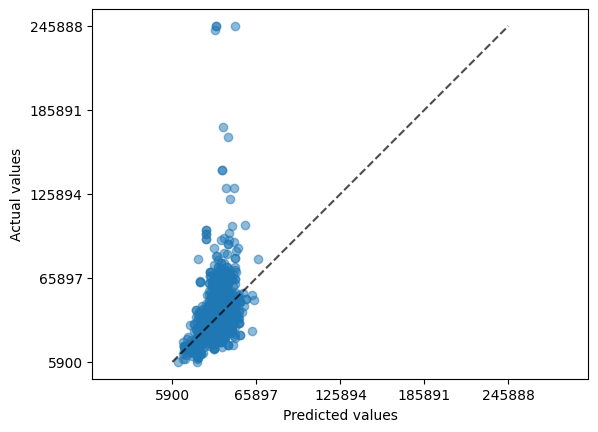

In [599]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_num_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

## Поиск Лучших Гиперпараметров по Сетке Параметров

In [601]:
pipe_num_transform

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_mileage',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Mileage']),
                                                 ('num_sr',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SellerRating']),
                                                 ('num_year',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=30),
                                            transformer=PowerTransformer()))])

In [606]:
param_grid = {
    # ВАЖНО: используем "имена", которые есть у компонент Pipeline и разделяем их __ (две земли)
    "preprocessors__num_mileage__QuantReplace__threshold": [0, 0.01],
    "model__regressor__n_neighbors": np.arange(1,50,8),
    "model__regressor__weights": ['uniform', 'distance'],
}

In [607]:
scorer = make_scorer(r2_score)

In [608]:
Pipe_GS = GridSearchCV(estimator = pipe_num_transform, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                       cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       scoring = scorer, # указываем метрику которую оптимизируем
                       verbose = 3 # 3 чтобы он всё подробно расписал, если не интересно - пишем 0
                       )
Pipe_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num_mileage',
                                                                         Pipeline(steps=[('QuantReplace',
                                                                                          QuantileReplacer(threshold=0.01)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Mileage']),
                                                                        ('num_sr',
                                                                         Pipeline(steps=[('QuantReplace',
                                                                                          QuantileReplacer(thre...
                                                                         ['Year'])])),
                                       ('model',
                                        TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=30),
                                                                   transformer=PowerTransformer()))]),
             param_grid={'model__regressor__n_neighbors': array([ 1,  9, 17, 25, 33, 41, 49]),
                         'model__regressor__weights': ['uniform', 'distance'],
                         'preprocessors__num_mileage__QuantReplace__threshold': [0,
                                                                                 0.01]},
             scoring=make_scorer(r2_score), verbose=3)

In [609]:
Pipe_GS.fit(X_train, y_train);

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_mileage__QuantReplace__threshold=0;, score=-0.770 total time=   0.1s
[CV 2/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_mileage__QuantReplace__threshold=0;, score=-0.782 total time=   0.0s
[CV 3/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_mileage__QuantReplace__threshold=0;, score=-0.534 total time=   0.0s
[CV 4/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_mileage__QuantReplace__threshold=0;, score=-0.430 total time=   0.1s
[CV 5/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessors__num_mileage__QuantReplace__threshold=0;, score=-0.272 total time=   0.0s
[CV 1/5] END model__regressor__n_neighbors=1, model__regressor__weights=uniform, preprocessor

In [610]:
Pipe_best=Pipe_GS.best_estimator_
Pipe_best

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_mileage',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Mileage']),
                                                 ('num_sr',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SellerRating']),
                                                 ('num_year',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year'])])),
                ('model',
                 TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=41),
                                            transformer=PowerTransformer()))])

In [611]:
Pipe_best.fit(X_train, y_train);

In [612]:
print(f"r2 на тренировочной выборке: {calculate_metric(Pipe_best, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(Pipe_best, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(Pipe_best, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(Pipe_best, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.1416
r2 на валидационной выборке: 0.1031
mse на тренировочной выборке: 373824475.7055
mse на валидационной выборке: 421880411.5655


### Проанализируем результат

На уровне гиперпараметров

In [613]:
DF_Pipe = pd.DataFrame(Pipe_GS.cv_results_)
DF_Pipe.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__regressor__n_neighbors',
       'param_model__regressor__weights',
       'param_preprocessors__num_mileage__QuantReplace__threshold', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [616]:
DF_ = DF_Pipe[[
       'param_model__regressor__n_neighbors',
       'param_model__regressor__weights',
       'param_preprocessors__num_mileage__QuantReplace__threshold',
                 'mean_test_score', #среднее значение метрики на кросс-валидации
             'std_test_score', # разброс метрики на кросс-валидации
             'rank_test_score',# место
             ]]
cm = sns.light_palette("orange", as_cmap=True) # делаем расцветку по значению. В этот раз "50 оттенков Оранжевого"
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm) # сортируем по убыванию места и раскрашиваем
hl

,param_model__regressor__n_neighbors,param_model__regressor__weights,param_preprocessors__num_mileage__QuantReplace__threshold,mean_test_score,std_test_score,rank_test_score
21,41,uniform,0.010000,0.164072,0.050675,1
17,33,uniform,0.010000,0.161745,0.046813,2
25,49,uniform,0.010000,0.159449,0.046025,3
24,49,uniform,0,0.154555,0.032428,4
20,41,uniform,0,0.153590,0.034072,5
16,33,uniform,0,0.152021,0.035664,6
13,25,uniform,0.010000,0.149946,0.049990,7
9,17,uniform,0.010000,0.145966,0.049555,8
12,25,uniform,0,0.144418,0.043075,9
8,17,uniform,0,0.136982,0.040074,10


Небольшие выводы:

* предпочительней тип весов также `uniform`.

* рост числа соседей после `9` не несет значительный вклад

* в предварительной обработке не принципиально удалять редкие значения признаков или нет



### Сохраняем модель

In [617]:
from joblib import dump, load # в scikit-learn ничего такого особенного нет
# пользуемся joblib

In [618]:
dump(model, 'model.joblib')  # чтобы сохранить объект
dump(kNNbest, 'best_knn.joblib')  # чтобы сохранить объект
dump(Pipe_best, 'Pipe_best_knn.joblib')  # чтобы сохранить объект

['Pipe_best_knn.joblib']